# Astrometry Response functions (Maps)

## This code is now OK

The key was setting everything in Ecliptic coordinates :)

In [62]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

In [73]:
# Going from ecliptic coordinates to spherical ones.
# Velocity with respect to the cosmic frame (in galactic coordinates(l, b) = (264◦, 48◦)):
v_theta = np.pi/2 - np.radians(-11.397) # (pi/2 - Declination) E[0,pi]
v_phi = np.radians(171.60) # Right Ascension E[0,2pi]

In [74]:
# unit vector in R3. 
#Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function returns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Uniform stars and fixed velocity

In [75]:
def vecdot(a,b): # (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=0)
    return dot
    
#a=[[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
#b=[[0,1,1]]
#adotb=vecdot(a,b)
#print(adotb)

def hola(y):
    return np.where(y == 0, 0, np.log(y))    
#print(hola(2))

def F0(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*(1- 8*y +7*(y**2) - 6*(y**2)*hola(y))
    den = 3* ((1-y)**2)
    return num/den

def F1(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = -np.pi*(2*y -1) *((y-1)*(2*y +1) - 3*y*hola(y))
    den = 6*((y-1)**3)
    return num/den

def F2(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*y*((y-1)*(2*y +1) - 3*y*hola(y))
    den = 3*((y-1)**2)
    return num/den

def TraceGTanalytic_H1_ij(v, n1, n2):
    y = (1-vecdot(n1,n2))/2 
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    n1n2 = vecdot(n1,n2)
    factor = 2*(n1v+n2v)/n1v
    t1 = - F2(v,n1,n2)*(n1v + n2v - 2*n1v*y)
    t2 = F1(v,n1,n2)*(n1v - n2v)*( 1 + 6*(y-1)*y + n1n2*(2*y -1))/(2*y -1)
    return (t1+t2)*factor


## Changing the color of the map according to a function

In [76]:
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)
print(unit_vector)
print(np.dot(unit_vector,unit_vector))

[-0.91077178 -0.3934311  -0.12532653]
1.0


dir shape: (3, 19200)
v shape: (3, 1)
vm shape: (3, 1)


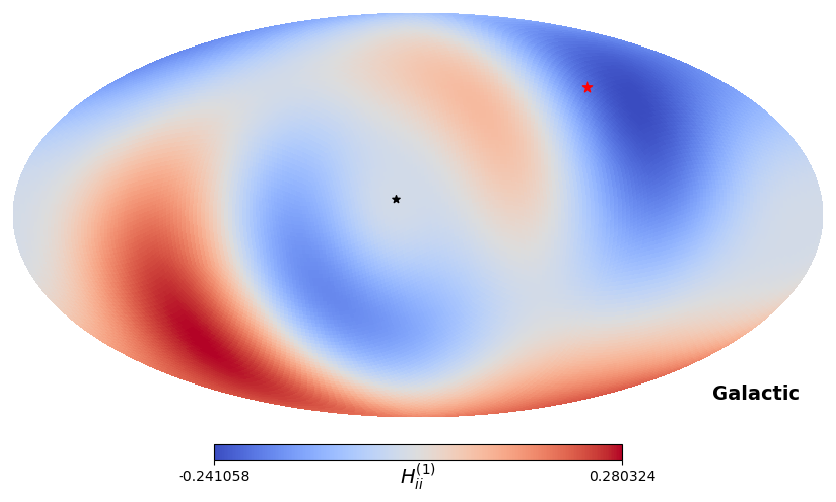

In [122]:
nside = 40 # 40 is a good number too. Kernel dies with 50 and larger numbers
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
dir = skyvec(theta,phi) #.T#.reshape(npix,3)

v = skyvec(v_theta, v_phi).reshape(3,1)
vn = skyvec(v_theta, v_phi).reshape(3,1) # Same direction as velocity 
#vn = skyvec(v_theta, v_phi+0.1).reshape(3,1) # Close to the velocity
#vn = -1.*np.array(v) # Opposite to the velocity
#vn = unit_vector.reshape(3,1) # Random position
vs = -1.*np.array(v)
thetaVn, phiVn = hp.vec2ang(vn)
thetaVs, phiVs = hp.vec2ang(vs)

######### Ameek's values #########
#theta1, phi1 = (np.radians(16), np.radians(228))
theta1, phi1 = (np.pi/2 -np.radians(5.53), np.radians(266.83))
n1 = skyvec(theta1,phi1).reshape(3,1)

print('dir shape:',np.shape(dir))
print('v shape:',np.shape(v))
print('vm shape:',np.shape(vn))

Map_H1_ij = TraceGTanalytic_H1_ij(v,dir,n1)

########## WARNING! Make sure these coordinates are really in Equatorial system!! 
hp.mollview(Map_H1_ij,title=r'',cmap='coolwarm',cbar=True, unit=r'$H^{(1)}_{ii}$',coord=['E','G'])
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r',coord=['E','G'])
#hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='w',coord=['E','G'])
hp.projscatter(theta1, phi1,marker='*',s=30,color='k',coord=['E','G']) 

#plt.savefig('H_00_VoppositeD.pdf',bbox_inches='tight')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/H_00_RandomStar.pdf')#,bbox_inches='tight')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_00_StarCloseToV.pdf')


In [120]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Example Galactic Coordinates in radians
l_rad = 0 * u.rad  # Galactic longitude (in radians)
b_rad = 0 * u.rad  # Galactic latitude (in radians)

# Create SkyCoord object for the Galactic coordinates with radians
galactic_coords = SkyCoord(l=l_rad, b=b_rad, frame='galactic')

# Convert to ecliptic coordinates (ICRS frame)
ecliptic_coords = galactic_coords.transform_to('barycentrictrueecliptic')

# Print the results
print(f"Ecliptic Longitude: {ecliptic_coords.lon}")
print(f"Ecliptic Latitude: {ecliptic_coords.lat}")


Ecliptic Longitude: 266.835649783549 deg
Ecliptic Latitude: -5.53632806471174 deg


In [118]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Example Galactic Coordinates
l = 0 * u.deg  # Galactic longitude
b = 0 * u.deg   # Galactic latitude

# Create SkyCoord object for the Galactic coordinates
galactic_coords = SkyCoord(l=l, b=b, frame='galactic')

# Convert to ecliptic coordinates (ICRS frame)
ecliptic_coords = galactic_coords.transform_to('barycentrictrueecliptic')

# Print the results
print(f"Ecliptic Longitude: {ecliptic_coords.lon}")
print(f"Ecliptic Latitude: {ecliptic_coords.lat}")


Ecliptic Longitude: 266.835649783549 deg
Ecliptic Latitude: -5.53632806471174 deg
